In [1]:
import numpy as np
import pandas as pd


from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.gaussian_process.kernels import RBF,Matern
from sklearn.gaussian_process import GaussianProcessRegressor

import pickle

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
%matplotlib inline
import scipy


/home/wxk/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load the data
train =pd.read_csv('../data/intern_data.csv').iloc[:,1:]
test = pd.read_csv('../data/intern_test.csv').iloc[:,1:]
num = train.shape[0]

#merge training set with testing test before center the data
tr_te = pd.concat((train, test), axis = 0)
#convert categorical column to dummy variable
tr_te_num = pd.get_dummies(tr_te)

In [3]:
# center the dataset
tr_te_num  = tr_te_num.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
xtrain,xtest = np.split(tr_te_num.loc[:, tr_te_num.columns != 'y'], [num], axis=0)
xtrain = xtrain.values
xtest = xtest.values

# original y is used
y = train.loc[:,'y']


In [4]:
# create the KFold instance
nfolds = 5
folds = KFold(len(y), n_folds = nfolds, shuffle = True, random_state = 2018)

# create two arrays to hold the prediction on training set and testing set
preds_train = np.zeros(xtrain.shape[0])
preds_test = np.zeros(xtest.shape[0])

fold_index = 1
for (inTr, inVal) in folds:
    # split the training set 
    xtr = xtrain[inTr]
    ytr = y[inTr]
    xval = xtrain[inVal] 
    yval = y[inVal]
 
    # Define a isotropic Matern kernel
    kernel_Matern = 1.0 * Matern([1.0]*xtrain.shape[1])
    
    # train and save the trained model
    file_name = '../trained_model/gp'+str(fold_index)+".sav"
    gp = GaussianProcessRegressor(kernel = kernel_Matern, n_restarts_optimizer=1)
    gp.fit(xtr, ytr)
    pickle.dump(gp, open(file_name, 'wb'))
    
    # predict on the validation set
    pred = gp.predict(xval, return_std=False)
    score = mean_absolute_error(yval, pred)
    preds_train[inVal] = pred
    print('Fold ', fold_index, '- MAE:', score)
    fold_index += 1
    
    #predict on the testing set
    preds_test += gp.predict(xtest,return_std = False)
    
# average and save the predictions on testing set 
preds_test /= nfolds 
test["prediction"] = preds_test
test.to_csv("../output/submission_GP.csv",index=False)

Fold  1 - MAE: 0.0998985937808
Fold  2 - MAE: 0.115097034445
Fold  3 - MAE: 0.0942147418984
Fold  4 - MAE: 0.108576533026
Fold  5 - MAE: 0.109740396712


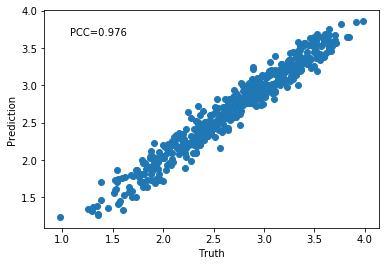

In [5]:
# visualize the prediction on the training set
fig = plt.figure(figsize= (6,4))

plt.scatter(y,preds_train)
plt.xlabel('Truth')
plt.ylabel('Prediction')

PCC = round(scipy.stats.pearsonr(y,preds_train)[0],3)

plt.text(np.min(y)*1.1, 0.95*np.max(preds_train), r'PCC='+str(PCC),
         fontsize=10)